In [ ]:
#Build a neural network attempt #2
#done best with keras modeling
#also attempted with RBM/Logistic Regression pipeline

In [35]:
import cv2
import glob
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import clone
%matplotlib inline

import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical

In [24]:
path = '/Users/colette/Downloads/style-color-images/style/'
#files = [os.path.basename(x) for x in glob.glob(path + '*.png')]

In [25]:
train = pd.read_csv('/Users/colette/Downloads/style-color-images/style/style.csv')
train.head(5)

,brand_name,brand_label,product_name,product_label,file
0,Christian Louboutin,0,shoes,0,0_0_001.png
1,Christian Louboutin,0,shoes,0,0_0_002.png
2,Christian Louboutin,0,shoes,0,0_0_003.png
3,Christian Louboutin,0,shoes,0,0_0_004.png
4,Christian Louboutin,0,shoes,0,0_0_005.png


In [26]:
image_coll = []

for i in tqdm(range(train.shape[0])):
    img = image.load_img(path+train['file'][i],target_size=(40,40,3))
    img = image.img_to_array(img)
    img = img/255
    image_coll.append(img)
    
X = np.array(image_coll)

100%|██████████| 2184/2184 [00:05<00:00, 418.39it/s]


In [27]:
X.shape

(2184, 40, 40, 3)

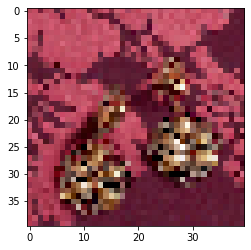

In [28]:
plt.imshow(X[842])

In [29]:
train['product_name'][842]

'earrings'

In [30]:
train = pd.concat([train, pd.get_dummies(train.product_name, prefix="product_name", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(train.product_name, prefix="product_name", drop_first=True).columns)

In [11]:
#nsamples, nX, ny, n3 = X.shape
#X = X.reshape((nsamples,nX*ny*n3))

In [31]:
X.shape

(2184, 40, 40, 3)

In [46]:
#y = train['product_name']
y = np.array(train.drop(['file', 'product_name', 'brand_name'],axis=1))
y.shape

(2184, 11)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [49]:
#scaler = StandardScaler()
# Fit only to the training data
#scaler.fit(X_train)

In [50]:
X_train.shape

(1965, 40, 40, 3)

In [51]:
y_train.shape

(1965, 11)

In [52]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(40,40,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(11, activation='sigmoid'))

In [53]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 36, 36, 16)        1216      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 18, 18, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 11)                57035     
Total params: 58,251
Trainable params: 58,251
Non-trainable params: 0
_________________________________________________________________


In [54]:
start_time = time.time()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

print("--- %s seconds ---" % round(time.time() - start_time, 2))

Train on 1965 samples, validate on 219 samples
Epoch 1/10
1965/1965 [==============================] - 1s 578us/step - loss: -5.0532 - acc: 0.7357 - val_loss: -6.0700 - val_acc: 0.7688
Epoch 2/10
1965/1965 [==============================] - 1s 420us/step - loss: -6.3456 - acc: 0.7580 - val_loss: -6.1181 - val_acc: 0.7717
Epoch 3/10
1965/1965 [==============================] - 1s 357us/step - loss: -6.3763 - acc: 0.7623 - val_loss: -6.1399 - val_acc: 0.7783
Epoch 4/10
1965/1965 [==============================] - 1s 387us/step - loss: -6.3946 - acc: 0.7660 - val_loss: -6.1397 - val_acc: 0.7787
Epoch 5/10
1965/1965 [==============================] - 1s 387us/step - loss: -6.4032 - acc: 0.7666 - val_loss: -6.1553 - val_acc: 0.7812
Epoch 6/10
1965/1965 [==============================] - 1s 377us/step - loss: -6.4145 - acc: 0.7713 - val_loss: -6.1578 - val_acc: 0.7825
Epoch 7/10
1965/1965 [==============================] - 1s 364us/step - loss: -6.4204 - acc: 0.7718 - val_loss: -6.1649 - val

In [18]:
logistic = LogisticRegression(solver='newton-cg', tol=1,
                                           multi_class='multinomial')

rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

In [19]:
# Training

import time

start_time = time.time()

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 1e-05
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, y_train)

print("--- %s seconds ---" % round(time.time() - start_time, 2))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -3280.91, time = 1.44s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -3216.86, time = 1.50s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -3156.08, time = 1.43s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -3102.37, time = 1.48s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -3054.28, time = 1.54s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -3010.43, time = 1.52s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -2970.11, time = 1.56s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -2932.91, time = 1.54s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -2898.34, time = 1.63s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -2866.36, time = 1.67s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -2836.73, time = 1.56s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -2809.18, time = 1.50s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -2783.56, time = 1.53s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -2759.69, time = 1.46s
[

In [55]:
# Evaluation

y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (classification_report(y_test, y_pred)))

y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (classification_report(y_test, y_pred)))

ValueError: Found array with dim 4. Estimator expected <= 2.

In [21]:
set(y_test) - set(y_pred)

set()

In [22]:
f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))

0.4636777981569908

In [ ]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()